# Preparations

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip /content/gdrive/MyDrive/data.zip -d /content/data

Streaming output truncated to the last 5000 lines.
  inflating: /content/data/melanoma_cancer_dataset/train/benign/melanoma_1348.jpg  
  inflating: /content/data/melanoma_cancer_dataset/train/benign/melanoma_250.jpg  
  inflating: /content/data/melanoma_cancer_dataset/train/benign/melanoma_2562.jpg  
  inflating: /content/data/melanoma_cancer_dataset/train/benign/melanoma_9789.jpg  
  inflating: /content/data/melanoma_cancer_dataset/train/benign/melanoma_4086.jpg  
  inflating: /content/data/melanoma_cancer_dataset/train/benign/melanoma_3030.jpg  
  inflating: /content/data/melanoma_cancer_dataset/train/benign/melanoma_4665.jpg  
  inflating: /content/data/melanoma_cancer_dataset/train/benign/melanoma_1161.jpg  
  inflating: /content/data/melanoma_cancer_dataset/train/benign/melanoma_3931.jpg  
  inflating: /content/data/melanoma_cancer_dataset/train/benign/melanoma_804.jpg  
  inflating: /content/data/melanoma_cancer_dataset/train/benign/melanoma_204.jpg  
  inflating: /content/data/m

In [ ]:
import torch
import torch.nn as nn
print(torch.__version__)
import os

2.1.0+cu121


In [ ]:
!pip install lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 777.7/777.7 kB 20.7 MB/s eta 0:00:00


In [ ]:
from tqdm.notebook import tqdm
import torch
import torchvision
import torchvision.transforms as t_transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
from torch.utils.data import DataLoader, SubsetRandomSampler, TensorDataset, random_split, SubsetRandomSampler, ConcatDataset
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold

In [ ]:
import lightning as L
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping
import torchmetrics
import torchvision.transforms.functional as F
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import random
from lightning.pytorch.callbacks import ModelSummary
import os
def set_seed(seed: int = 0) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")
set_seed()

Random seed set as 0


# Split Data

In [ ]:
benign_data_path = "/content/data/melanoma_cancer_dataset/train/benign"
malignant_data_path = "/content/data/melanoma_cancer_dataset/train/benign"
# count the number of images in each folder
benign_data_size = len(os.listdir(benign_data_path))
malignant_data_size = len(os.listdir(malignant_data_path))
print("benign_data_size: ", benign_data_size)
print("malignant_data_size: ", malignant_data_size)

benign_data_size:  5500
malignant_data_size:  5500


In [ ]:
import shutil
from sklearn.model_selection import train_test_split

# Define the directories
base_dir = '/content/data/melanoma_cancer_dataset/train'
categories = ['benign', 'malignant']

# Create train, validation, and test directories
for dir_name in ['train', 'validation', 'test']:
    for category in categories:
        os.makedirs(os.path.join(dir_name, category), exist_ok=True)

# Split the data
for category in categories:
    files = os.listdir(os.path.join(base_dir, category))
    train_files, temp_files = train_test_split(files, test_size=0.2, random_state=42)
    validation_files, test_files = train_test_split(temp_files, test_size=0.5, random_state=42)

    # Move the files
    for file in train_files:
        shutil.move(os.path.join(base_dir, category, file), os.path.join('train', category, file))
    for file in validation_files:
        shutil.move(os.path.join(base_dir, category, file), os.path.join('validation', category, file))
    for file in test_files:
        shutil.move(os.path.join(base_dir, category, file), os.path.join('test', category, file))

- Tạo thư mục cho tập train, validation và test . Mỗi thư mục chứa 2 thư mục con là benign và malignant  

- files là mảng chứa tên của tất cả các tệp trong thư mục tương ứng với loại dữ liệu (benign hoặc malignant).  

- Sau đó mảng được tách ra thành các mảng con tương ứng với train test validation với tỷ lệ 8-1-1.(sử dụng train_test_split của thư viện sklearn)  

- Từ đó chuyển các files từ thư mục gốc sang các thư mục train test validation đã chia ở trên.  

In [ ]:
base_dir = 'data'
categories = ['benign', 'malignant']
for dir_name in ['train', 'validation', 'test']:
    for category in categories:
        num_files = len(os.listdir(os.path.join(dir_name, category)))
        print(f'There are {num_files} files in {os.path.join(dir_name, category)}')

There are 4400 files in train/benign
There are 4084 files in train/malignant
There are 550 files in validation/benign
There are 510 files in validation/malignant
There are 550 files in test/benign
There are 511 files in test/malignant


- Đếm các files trong các thư mục vừa tạo trên

In [ ]:
transforms = t_transforms.Compose([t_transforms.Resize((224, 224)),
                                 t_transforms.ToTensor(),
                                  t_transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                                 ])
batch_size = 20
train_set = torchvision.datasets.ImageFolder(root='train', transform=transforms)
test_set = torchvision.datasets.ImageFolder(root='test', transform=transforms)
print(train_set.classes)
print(test_set.classes)

['benign', 'malignant']
['benign', 'malignant']


In [ ]:
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True)

In [ ]:
train_dataiter = iter(train_loader)
train_images, train_labels = next(train_dataiter)
print(train_images.shape)

torch.Size([20, 3, 224, 224])


- import torchvision.transforms as t_transforms

- Sử dụng method có sẵn trong torchvision để tạo datasets từ thư mục chứa ảnh (torchvision.datasets.ImageFolder) đồng thời chuyển đỗi kích thước ảnh về (224,224) số hóa theo pytorch (ToTensor) sau đó chuẩn hóa (Normalize)  

- Cuối cùng dùng DataLoader của torch.ultils.data để đưa về DataLoader object với batch_size cho trước

In [ ]:
def imshow(img):
    img = F.normalize(img, mean=(-0.485/0.229, -0.456/0.224, -0.406/0.225), std=(1/0.229, 1/0.224, 1/0.225))  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

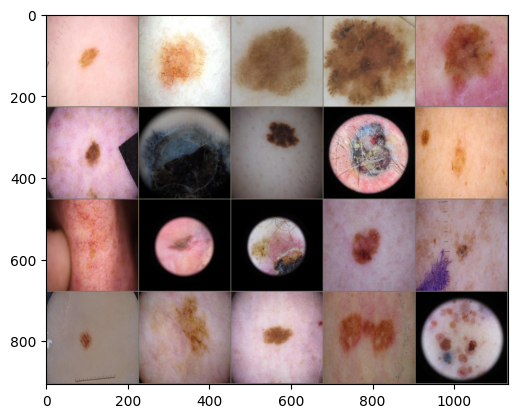

Labels: tensor([0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1])


In [ ]:
data_iter = iter(train_loader)
images, labels = next(data_iter)

imshow(torchvision.utils.make_grid(images, nrow = 5))
print("Labels:", labels)


- Plot ảnh mẫu trong train_loader

# Define DataModule

In [ ]:
class DataModule(L.LightningDataModule):
    def __init__(self, batch_size, num_workers, train_path, val_path,test_path):
        super(DataModule, self).__init__()
        self.train_path = train_path
        self.val_path = val_path
        self.test_path = test_path
        self.batch_size = batch_size
        self.num_workers = num_workers

        self.train_transforms = t_transforms.Compose(
            [
                t_transforms.Resize((224, 224)),
                t_transforms.RandomHorizontalFlip(),
                t_transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.1),
                t_transforms.ToTensor(),
                t_transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
            ]
        )
        self.test_transforms = t_transforms.Compose(
            [
                t_transforms.Resize((224, 224)),
                t_transforms.ToTensor(),
                t_transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
            ]
        )
    transforms = t_transforms.Compose([t_transforms.Resize((224, 224)),
                                 t_transforms.ToTensor(),
                                 t_transforms.Normalize((0.5,), (0.5,))])

    def setup(self, stage=None):
        self.train_dataset = torchvision.datasets.ImageFolder(root=self.train_path, transform=self.train_transforms)
        self.val_dataset = torchvision.datasets.ImageFolder(root=self.val_path, transform=self.test_transforms)
        self.test_dataset = torchvision.datasets.ImageFolder(root=self.test_path, transform=self.test_transforms)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers)



Khởi tạo DataModule kế thừa từ LightningDataModule của Ligthning để tạo ra được 1 Module có thể trực tiếp đưa vào trainer của Lightning với 3 data_loader phân biệt là train, validation và test.  

Đối tượng DataModule nhận các tham số là :

- batch_size : kích thước của 1 batch

- num_workers : số lượng worker được sử dụng để load data

- train_path : đường dẫn đến thư mục chứa data train

- val_path : đường dẫn đến thư mục chứa data validation

- test_path : đường dẫn đến thư mục chứa data test

- train_transforms : các transform được sử dụng cho việc chuẩn bị data phù hợp với quá trình train model,chuẩn hóa dữ liệu và tăng cường dữ liệu (augmentation).  

- phương thức setup() : chuẩn bị dữ liệu trước khi bắt đầu quá trình huấn luyện, tạo trước các lớp datasets để sử dụng cho việc tạo các data_loader.  

- phương thức train_dataloader(), val_dataloader(), test_dataloader() : trả về các data_loader tương ứng với train, validation và test.               

# Using Pytorch Module (provided) :

### Using VGG16

In [ ]:
class VGG16(nn.Module):
    def __init__(self, num_classes=2):
        super(VGG16, self).__init__()
        self.features = self._make_layers()
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def _make_layers(self):
        layers = []
        in_channels = 3

        vgg_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M']

        for v in vgg_config:
            if v == 'M':
                layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
            else:
                conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
                layers += [conv2d, nn.ReLU(inplace=True)]
                in_channels = v

        return nn.Sequential(*layers)

# Define a LightningModule using the custom VGG16
class CustomVGG16(L.LightningModule):
    def __init__(self, num_classes=2, lr=1e-4):
        super(CustomVGG16, self).__init__()
        self.model = VGG16(num_classes)
        self.lr = lr
        self.loss = torch.nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss(y_hat, y)
        accuracy = (y_hat.argmax(dim=1) == y).float().mean()
        self.log_dict({'loss': loss, 'acc': accuracy}, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        val_loss = self.loss(y_hat, y)
        val_accuracy = (y_hat.argmax(dim=1) == y).float().mean()
        self.log_dict({'val_loss': val_loss, 'val_acc': val_accuracy}, prog_bar=True)
        return val_loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        test_loss = self.loss(y_hat, y)
        test_accuracy = (y_hat.argmax(dim=1) == y).float().mean()
        self.log_dict({'test_loss': test_loss, 'test_acc': test_accuracy}, prog_bar=True)
        return test_loss

    def predict_step(self, batch, batch_idx, dataloader_idx=None):
        x, _ = batch['images'], batch['labels']
        y_hat = self(x)
        probabilities = torch.softmax(y_hat, dim=1)
        predicted_labels = torch.argmax(probabilities, dim=1)
        return {"y_pred": predicted_labels}

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer

1)

Khởi tạo lớp VGG16 từ nn.Module (torch neuralnetwork) để tạo ra được một mạng VGG16 có thể sử dụng được trong quá trình huấn luyện gồm 2 phần chính là feature và classifier.

- feature : là phần trích xuất đặc trưng của mạng VGG16, được khởi tạo từ các lớp Conv2d, MaxPool2d, ReLU và được tạo qua phuong thức make_layers().

- classifier : là phần phân loại thêm sau VGG16, được khởi tạo từ các lớp Linear, ReLU, Dropout và Softmax .

- phương thức forward() : thực hiện quá trình lan truyền thuận của mạng VGG16. khi đó input sẽ được đưa qua phần feature để trích xuất đặc trưng và sau đó được đưa qua phần classifier để phân loại (tức là prediction).

class CustomVGG16(L.LightningModule):
Lớp CustomVGG16 kế thừa từ LightningModule của Lightning để tạo ra được 1 Module có thể trực tiếp đưa vào trainer của Lightning và có thể sử dụng được các phương thức của LightningModule.  

2)

Khởi tạo một mô hình VGG16 từ lớp VGG16 ở trên với số lượng class là 2. Sau đó tùy chỉnh các phương thức của LightningModule để phù hợp với mô hình VGG16.
    
* forward() :
thực hiện quá trình lan truyền thuận của mạng VGG16.

* training_step() :
thực hiện quá trình lan truyền thuận (self.x) và trả về loss của một batch.

* validation_step() :
Tương tự như training_step() nhưng trong quá trình validation.  

* test_step() :
Tương tự như training_step() nhưng trong quá trình test.  

* predict_step() :
Định nghĩa cách tính toán dự đoán khi sử dụng mô hình để dự đoán trên một batch dữ liệu, trả về kết quả dự đoán.  

* configure_optimizers() :
khởi tạo optimizer với learning rate cho mô hình VGG16.

    



In [ ]:
!pip install -q torchinfo

In [ ]:
# from torchsummary import summary
from torchinfo import summary

model = CustomVGG16()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
summary(model, (32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
CustomVGG16 (CustomVGG16)                [32, 3, 224, 224]    [32, 2]              --                   True
├─VGG16 (model)                          [32, 3, 224, 224]    [32, 2]              --                   True
│    └─Sequential (features)             [32, 3, 224, 224]    [32, 512, 7, 7]      --                   True
│    │    └─Conv2d (0)                   [32, 3, 224, 224]    [32, 64, 224, 224]   1,792                True
│    │    └─ReLU (1)                     [32, 64, 224, 224]   [32, 64, 224, 224]   --                   --
│    │    └─Conv2d (2)                   [32, 64, 224, 224]   [32, 64, 224, 224]   36,928               True
│    │    └─ReLU (3)                     [32, 64, 224, 224]   [32, 64, 224, 224]   --                   --
│    │    └─MaxPool2d (4)                [32, 64, 224, 224]   [32, 64, 112, 112]   --                   --
│    │    └─Conv2d (

- Write Log for VGG16

In [ ]:
from pytorch_lightning.loggers import WandbLogger
wandb_logger = WandbLogger(name='VGG16-skinCancer', project='MLA_skinCancer')

model_checkpoint = ModelCheckpoint(dirpath='checkpoint/',
                                   monitor="val_acc",
                                   verbose=True,
                                   mode="max",
                                   save_top_k=1
                                   )
early_stopping = EarlyStopping(monitor="val_acc", mode="max", min_delta=1e-4, patience=5)
callbacks = [model_checkpoint, early_stopping, ModelSummary(max_depth=1)]

model = CustomVGG16()
batch_size = 32

dataModule = DataModule(batch_size=batch_size, num_workers=2, train_path='train', val_path='validation',test_path='test')
dataModule.setup()

trainer = L.Trainer(max_epochs=10,callbacks=callbacks,logger=wandb_logger)

trainer.fit(model, dataModule)

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
wandb: Currently logged in as: cristianoronalbaydi (cristiano_ronalbaydi). Use `wandb login --relogin` to force relogin


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name  | Type             | Params
-------------------------------------------
0 | model | VGG16            | 134 M 
1 | loss  | CrossEntropyLoss | 0     
-------------------------------------------
134 M     Trainable params
0         Non-trainable params
134 M     Total params
537.075   Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name  | Type             | Params
-------------------------------------------
0 | model | VGG16            | 134 M 
1 | loss  | CrossEntropyLoss | 0     
-------------------------------------------
134 M     Trainable params
0         Non-trainable params
134 M     Total params
537.075   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 266: 'val_acc' reached 0.79245 (best 0.79245), saving model to '/content/checkpoint/epoch=0-step=266.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 532: 'val_acc' reached 0.86038 (best 0.86038), saving model to '/content/checkpoint/epoch=1-step=532.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 798: 'val_acc' reached 0.89528 (best 0.89528), saving model to '/content/checkpoint/epoch=2-step=798.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 1064: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 1330: 'val_acc' reached 0.91698 (best 0.91698), saving model to '/content/checkpoint/epoch=4-step=1330.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 5, global step 1596: 'val_acc' reached 0.91981 (best 0.91981), saving model to '/content/checkpoint/epoch=5-step=1596.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 6, global step 1862: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 7, global step 2128: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 8, global step 2394: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 9, global step 2660: 'val_acc' was not in top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


In [ ]:
trainer.test(model, dataModule)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9208294153213501     │
│         test_loss         │    0.19998519122600555    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.19998519122600555, 'test_acc': 0.9208294153213501}]

1)

Sử dụng WandbLogger từ thư viện pytorch_lightning.loggers để ghi log các thông số và kết quả của huấn luyện lên Weights & Biases (WandB).  

Sử dụng các Callbacks của Lightning :

- ModelCheckpoint :
lưu lại các checkpoint của mô hình trong quá trình huấn luyện khi val_acc tốt hơn các lần trước.

- EarlyStopping :
dừng quá trình huấn luyện khi val_acc không cải thiện trong một số epoch nhất định.

- ModelSummary :
hiển thị thông tin của mô hình.

2)

Tạo mô hình từ customVGG16 và dataModule với batch_size là 32 và num_workers là 2.

Truyền mô hình và dataModule vào trainer của Lightning để bắt đầu quá trình huấn luyện với các tham số :

- max_epochs :
số lượng epoch tối đa là 10.

- callbacks :
sử dụng các callbacks đã khởi tạo ở trên.

- logger :
sử dụng logger đã khởi tạo ở trên.



### Using ResNet152

In [94]:
class Model_resnet152_full(L.LightningModule):
  def __init__(self, is_train=False, learning_rate=1e-3,
               num_target_classes=2, optimizer_type="adam", loss_type="cross_entropy"):
    super(Model_resnet152_full, self).__init__()
    backbone = torchvision.models.resnet152(weights="DEFAULT") # ------ resnet152 OK
    num_filters = backbone.fc.in_features
    layers = list(backbone.children())[:-1]
    custom_fc = torch.nn.Sequential(
        torch.nn.Flatten(),
        torch.nn.Linear(num_filters, 512),  # Fully connected layer with 512 output features
        torch.nn.ReLU(),  # ReLU activation
        torch.nn.Dropout(0.5),  # Dropout layer
        torch.nn.Linear(512, num_target_classes)  # Fully connected layer with num_target_classes output
    )
    self.fc = custom_fc
    self.feature_extractor = torch.nn.Sequential(*layers)
    self.classifier = torch.nn.Linear(num_filters, num_target_classes)
    self.is_train = is_train
    self.learning_rate = learning_rate

    # define optimizer
    if optimizer_type == "adam":
        self.optimizer_name = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
    elif optimizer_type == "sgd":
        self.optimizer_name = torch.optim.SGD(self.parameters(), lr=self.learning_rate)
    else: raise ValueError("Invalid optimizer type.")

    # define loss function
    if loss_type == "cross_entropy":
        self.loss = torch.nn.CrossEntropyLoss()
    elif loss_type == "mse":
        self.loss = torch.nn.MSELoss()
    else: raise ValueError("Invalid loss function type")

    #define accuracy metrics
    self.accuracy = torchmetrics.classification.Accuracy(task="multiclass",
                                                         num_classes=num_target_classes)

  def configure_optimizers(self):
    return self.optimizer_name

  def compute_loss(self, y_pred, y):
    return self.loss(y_pred, y)

  def forward(self, x):
    self.feature_extractor.eval()
    if self.is_train:
      representations = self.feature_extractor(x).flatten(1)
    else:
      with torch.no_grad():
        representations = self.feature_extractor(x).flatten(1)
    x = self.classifier(representations)
    return x

  def training_step(self, batch, batch_idx):
    x, y = batch[0], batch[1]
    y_pred = self(x)
    train_loss = self.compute_loss(y_pred, y)
    acc = self.accuracy(y_pred, y)
    self.log_dict({'train_loss': train_loss, 'train_acc': acc} , prog_bar=True)
    return train_loss

  def validation_step(self, batch, batch_idx):
    x, y = batch[0], batch[1]
    y_pred = self(x)
    val_loss = self.compute_loss(y_pred, y)
    val_acc = self.accuracy(y_pred, y)
    self.log_dict({'val_loss': val_loss, 'val_acc': val_acc}, prog_bar=True)
    return val_loss

  def test_step(self, batch, batch_idx):
    x, y = batch[0], batch[1]
    y_pred = self(x)
    test_loss = self.compute_loss(y_pred, y)
    test_acc = self.accuracy(y_pred, y)
    self.log_dict({'test_loss': test_loss, 'test_acc': test_acc}, prog_bar=True)
    return test_loss

  def predict_step(self, batch, batch_idx, dataloader_idx=None):
    x = batch[0]
    with torch.no_grad():
        predictions = self.forward(x)
    predicted_probs = torch.softmax(predictions, dim=1)
    predicted_labels = predicted_probs.argmax(dim=1)
    return {"probs": predicted_probs, "labels": predicted_labels}


model = Model_resnet152_full()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
summary(model=model,
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
Model_resnet152_full (Model_resnet152_full)   [32, 3, 224, 224]    [32, 2]              1,050,114            True
├─Sequential (feature_extractor)              [32, 3, 224, 224]    [32, 2048, 1, 1]     --                   True
│    └─Conv2d (0)                             [32, 3, 224, 224]    [32, 64, 112, 112]   9,408                True
│    └─BatchNorm2d (1)                        [32, 64, 112, 112]   [32, 64, 112, 112]   128                  True
│    └─ReLU (2)                               [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
│    └─MaxPool2d (3)                          [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
│    └─Sequential (4)                         [32, 64, 56, 56]     [32, 256, 56, 56]    --                   True
│    │    └─Bottleneck (0)                    [32, 64, 56, 56]     [32, 256, 56, 56]   

- Write Log for ResNet152

In [95]:
from pytorch_lightning.loggers import WandbLogger
wandb_logger = WandbLogger(name='ResNet152-skinCancer', project='MLA_skinCancer')

model_checkpoint = ModelCheckpoint(dirpath='checkpoint/',
                                   monitor="val_acc",
                                   verbose=True,
                                   mode="max",
                                   save_top_k=1
                                   )
early_stopping = EarlyStopping(monitor="val_acc", mode="max", min_delta=1e-4, patience=5)
callbacks = [model_checkpoint, early_stopping, ModelSummary(max_depth=1)]

model = Model_resnet152_full()
batch_size = 32

dataModule = DataModule(batch_size=batch_size, num_workers=2, train_path='train', val_path='validation',test_path='test')
dataModule.setup()

trainer = L.Trainer(max_epochs=10,callbacks=callbacks,logger=wandb_logger)

trainer.fit(model, dataModule)

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name              | Type               | Params
---------------------------------------------------------
0 | fc                | Sequential         | 1.1 M 
1 | feature_extractor | Sequential         | 58.1 M
2 | classifier        | Linear             | 4.1 K 
3 | loss              | CrossEntropyLoss   | 0     


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 266: 'val_acc' reached 0.90755 (best 0.90755), saving model to '/content/checkpoint/epoch=0-step=266-v1.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 532: 'val_acc' reached 0.91038 (best 0.91038), saving model to '/content/checkpoint/epoch=1-step=532.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 798: 'val_acc' reached 0.91887 (best 0.91887), saving model to '/content/checkpoint/epoch=2-step=798.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 1064: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 1330: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 5, global step 1596: 'val_acc' reached 0.92264 (best 0.92264), saving model to '/content/checkpoint/epoch=5-step=1596.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 6, global step 1862: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 7, global step 2128: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 8, global step 2394: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 9, global step 2660: 'val_acc' was not in top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


In [96]:
trainer.test(model, dataModule)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9274269342422485     │
│         test_loss         │    0.19613176584243774    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.19613176584243774, 'test_acc': 0.9274269342422485}]

### Using EficientNet

In [ ]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.1/254.1 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.5 MB/s eta 0:00:00


In [ ]:
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

- Write Log for EfficietnNet

In [ ]:
!pip install efficientnet-pytorch

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=ca55c47f33a0cf5c5dd7b34ea65c061b3b05d0d436bcc0f8cf5fb2246d9094e6
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet-pytorch


In [ ]:
from efficientnet_pytorch import EfficientNet
class EfficientNet(nn.Module):
    def __init__(self, num_classes=2):
        super(EfficientNet, self).__init__()
        self.model = EfficientNet.from_pretrained('efficientnet-b7')
        in_features = self.model._fc.in_features
        self.model._fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.model(x)
from efficientnet_pytorch import EfficientNet
class CustomEfficientNet(L.LightningModule):
    def __init__(self, num_classes=2, lr=1e-4):
        super(CustomEfficientNet, self).__init__()
        self.model =  EfficientNet.from_pretrained('efficientnet-b7')
        in_features = self.model._fc.in_features
        self.model._fc = nn.Linear(in_features, num_classes)
        self.lr = lr
        self.loss = torch.nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss(y_hat, y)
        accuracy = (y_hat.argmax(dim=1) == y).float().mean()
        self.log_dict({'loss': loss, 'acc': accuracy}, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        val_loss = self.loss(y_hat, y)
        val_accuracy = (y_hat.argmax(dim=1) == y).float().mean()
        self.log_dict({'val_loss': val_loss, 'val_acc': val_accuracy}, prog_bar=True)
        return val_loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        test_loss = self.loss(y_hat, y)
        test_accuracy = (y_hat.argmax(dim=1) == y).float().mean()
        self.log_dict({'test_loss': test_loss, 'test_acc': test_accuracy}, prog_bar=True)
        return test_loss

    def predict_step(self, batch, batch_idx, dataloader_idx=None):
        x, _ = batch['images'], batch['labels']
        y_hat = self(x)
        probabilities = torch.softmax(y_hat, dim=1)
        predicted_labels = torch.argmax(probabilities, dim=1)
        return {"y_pred": predicted_labels}

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer


model = CustomEfficientNet()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
summary(model=model,
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b7-dcc49843.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b7-dcc49843.pth
100%|██████████| 254M/254M [00:02<00:00, 92.4MB/s]


Loaded pretrained weights for efficientnet-b7


Layer (type (var_name))                                           Input Shape          Output Shape         Param #              Trainable
CustomEfficientNet (CustomEfficientNet)                           [32, 3, 224, 224]    [32, 2]              --                   True
├─EfficientNet (model)                                            [32, 3, 224, 224]    [32, 2]              --                   True
│    └─Conv2dStaticSamePadding (_conv_stem)                       [32, 3, 224, 224]    [32, 64, 112, 112]   1,728                True
│    │    └─ZeroPad2d (static_padding)                            [32, 3, 224, 224]    [32, 3, 225, 225]    --                   --
│    └─BatchNorm2d (_bn0)                                         [32, 64, 112, 112]   [32, 64, 112, 112]   128                  True
│    └─MemoryEfficientSwish (_swish)                              [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
│    └─ModuleList (_blocks)                                  

Khởi tạo lớp EfficientNet từ nn.Module (torch neuralnetwork) để tạo ra được một mạng EfficientNet có thể sử dụng được trong quá trình huấn luyện gồm 2 phần chính là feature và classifier.

- feature : là phần trích xuất đặc trưng của mạng VGG16, được khởi tạo từ các lớp Conv2d, MaxPool2d, ReLU và được tạo qua phuong thức make_layers().
classifier : là phần phân loại thêm sau VGG16, được khởi tạo từ các lớp Linear, ReLU, Dropout và Softmax .

- phương thức forward() : thực hiện quá trình lan truyền thuận của mạng VGG16. khi đó input sẽ được đưa qua phần feature để trích xuất đặc trưng và sau đó được đưa qua phần classifier để phân loại (tức là prediction).

- class CustomEfficientNet(L.LightningModule):
Lớp CustomEfficientNet kế thừa từ LightningModule của Lightning để tạo ra được 1 Module có thể trực tiếp đưa vào trainer của Lightning và có thể sử dụng được các phương thức của LightningModule.  

    



In [ ]:
from pytorch_lightning.loggers import WandbLogger
wandb_logger = WandbLogger(name='EfficientNet-skinCancer', project='MLA_skinCancer')

model_checkpoint = ModelCheckpoint(dirpath='checkpoint/',
                                   monitor="val_acc",
                                   verbose=True,
                                   mode="max",
                                   save_top_k=1
                                   )
early_stopping = EarlyStopping(monitor="val_acc", mode="max", min_delta=1e-4, patience=5)
callbacks = [model_checkpoint, early_stopping, ModelSummary(max_depth=2)]

model = CustomEfficientNet()
batch_size = 32
dataModule = DataModule(batch_size=batch_size, num_workers=2, train_path='train', val_path='validation',test_path='test')
trainer = L.Trainer(max_epochs=10,callbacks=callbacks,logger=wandb_logger)

trainer.fit(model, dataModule)

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Loaded pretrained weights for efficientnet-b7


INFO: 
   | Name               | Type                    | Params
----------------------------------------------------------------
0  | model              | EfficientNet            | 63.8 M
1  | model._conv_stem   | Conv2dStaticSamePadding | 1.7 K 
2  | model._bn0         | BatchNorm2d             | 128   
3  | model._blocks      | ModuleList              | 62.1 M
4  | model._conv_head   | Conv2dStaticSamePadding | 1.6 M 
5  | model._bn1         | BatchNorm2d             | 5.1 K 
6  | model._avg_pooling | AdaptiveAvgPool2d       | 0     
7  | model._dropout     | Dropout                 | 0     
8  | model._fc          | Linear                  | 5.1 K 
9  | model._swish       | MemoryEfficientSwish    | 0     
10 | loss               | CrossEntropyLoss        | 0     
----------------------------------------------------------------
63.8 M    Trainable params
0         Non-trainable params
63.8 M    Total params
255.168   Total estimated model params size (MB)
INFO:lightning.pytorch.ca

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 531: 'val_acc' reached 0.93868 (best 0.93868), saving model to '/content/checkpoint/epoch=0-step=531.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 1062: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 1593: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 2124: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 2655: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 5, global step 3186: 'val_acc' was not in top 1


Nếu dùng EfficientNet thì cũng tương tự như trainer cho VGG16 nhưng batch_size là 16. Điều này cho thấy việc dùng EfficientNet sẽ tốn ít chi phí hơn ( bacth nhỏ hơn thay vì dùng batch = 32 )

Giải thích về EfficientNet có thể nói một số điều quan trọng như sau :

- Điểm chính của EfficientNet là giải quyết thách thức của việc tỷ lệ mô hình ( tỉ lệ thuận giữa độ phức tạp của mô hình và chi phí tính toán và lưu trữ ).
- Tránh việc tăng chi phí tính toán, bộ nhớ khi tăng độ sâu, rộng và độ phân giải.

So sánh với các kiến trúc khác như ResNet50, ResNet152, AlexNet, VGG16 và VGG19. ( Ở đây chúng ta chọn VGG16 để làm )

- EfficientNet thường có số lượng tham số ít hơn so với các kiến trúc lớn như ResNet152 chẳng hạn.
- EfficientNet được thiết kế với ít FLOP (floating-point operations per second) hơn các kiến trúc khác.



In [ ]:
trainer.test(model, dataModule)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9415645599365234     │
│         test_loss         │    0.2786484360694885     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.2786484360694885, 'test_acc': 0.9415645599365234}]

### Using MobileNet

Ngoài EfficientNet thì còn có thể dùng MobileNet. Ta sẽ cùng kiểm tra xem dùng MobileNet thì có thể tốn ít chi phí hơn không .

In [ ]:
import torch.nn as nn
import torchvision.models as models

class MobileNet(nn.Module):
    def __init__(self, num_classes=2):
        super(MobileNet, self).__init__()
        self.model = models.mobilenet_v2()
        in_features = self.model.classifier[-1].in_features
        self.model.classifier[-1] = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.model(x)

class CustomMobileNet(L.LightningModule):
    def __init__(self, num_classes=2, lr=1e-4, optimizer_type="adam", loss_type ="cross_entropy"):
        super(CustomMobileNet, self).__init__()
        self.model = MobileNet(num_classes=num_classes)
        self.lr = lr
        self.loss = torch.nn.CrossEntropyLoss()

        # define optimizer
        if optimizer_type == "adam":
            self.optimizer_name = torch.optim.Adam(self.parameters(), lr=self.lr)
        elif optimizer_type == "sgd":
            self.optimizer_name = torch.optim.SGD(self.parameters(), lr=self.lr)
        else: raise ValueError("Invalid optimizer type.")

        # define loss function
        if loss_type == "cross_entropy":
            self.loss = torch.nn.CrossEntropyLoss()
        elif loss_type == "mse":
            self.loss = torch.nn.MSELoss()
        else: raise ValueError("Invalid loss function type")

        #define accuracy metrics
        self.accuracy = torchmetrics.classification.Accuracy(task="multiclass",
                                                            num_classes=num_classes)

    def configure_optimizers(self):
        return self.optimizer_name

    def compute_loss(self, y_pred, y):
        return self.loss(y_pred, y)

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
      x, y = batch[0], batch[1]
      y_pred = self(x)
      train_loss = self.compute_loss(y_pred, y)
      acc = self.accuracy(y_pred, y)
      self.log_dict({'train_loss': train_loss, 'train_acc': acc} , prog_bar=True)
      return train_loss

    def validation_step(self, batch, batch_idx):
      x, y = batch[0], batch[1]
      y_pred = self(x)
      val_loss = self.compute_loss(y_pred, y)
      val_acc = self.accuracy(y_pred, y)
      self.log_dict({'val_loss': val_loss, 'val_acc': val_acc}, prog_bar=True)
      return val_loss

    def test_step(self, batch, batch_idx):
      x, y = batch[0], batch[1]
      y_pred = self(x)
      test_loss = self.compute_loss(y_pred, y)
      test_acc = self.accuracy(y_pred, y)
      self.log_dict({'test_loss': test_loss, 'test_acc': test_acc}, prog_bar=True)
      return test_loss

    def predict_step(self, batch, batch_idx, dataloader_idx=None):
      x = batch[0]
      with torch.no_grad():
          predictions = self.forward(x)
      predicted_probs = torch.softmax(predictions, dim=1)
      predicted_labels = predicted_probs.argmax(dim=1)
      return {"probs": predicted_probs, "labels": predicted_labels}

model = CustomMobileNet()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

summary(model=model,
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)


Layer (type (var_name))                                 Input Shape          Output Shape         Param #              Trainable
CustomMobileNet (CustomMobileNet)                       [32, 3, 224, 224]    [32, 2]              --                   True
├─MobileNet (model)                                     [32, 3, 224, 224]    [32, 2]              --                   True
│    └─MobileNetV2 (model)                              [32, 3, 224, 224]    [32, 2]              --                   True
│    │    └─Sequential (features)                       [32, 3, 224, 224]    [32, 1280, 7, 7]     2,223,872            True
│    │    └─Sequential (classifier)                     [32, 1280]           [32, 2]              2,562                True
Total params: 2,226,434
Trainable params: 2,226,434
Non-trainable params: 0
Total mult-adds (G): 9.58
Input size (MB): 19.27
Forward/backward pass size (MB): 3419.19
Params size (MB): 8.91
Estimated Total Size (MB): 3447.37

In [ ]:
from pytorch_lightning.loggers import WandbLogger
wandb_logger = WandbLogger(name='MobileNet-skinCancer', project='MLA_skinCancer')

model_checkpoint = ModelCheckpoint(dirpath='checkpoint/',
                                   monitor="val_acc",
                                   verbose=True,
                                   mode="max",
                                   save_top_k=1
                                   )
early_stopping = EarlyStopping(monitor="val_acc", mode="max", min_delta=1e-4, patience=5)
callbacks = [model_checkpoint, early_stopping, ModelSummary(max_depth=2)]

model = CustomMobileNet()
batch_size=32

dataModule = DataModule(batch_size=batch_size, num_workers=2, train_path='train', val_path='validation',test_path='test')
dataModule.setup()

In [ ]:
trainer = L.Trainer(max_epochs=10,callbacks=callbacks,logger=wandb_logger)
trainer.fit(model, dataModule)

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name        | Type               | Params
---------------------------------------------------
0 | model       | MobileNet          | 2.2 M 
1 | model.model | MobileNetV2        | 2.2 M 
2 | loss        | CrossEntropyLoss   | 0     
3 | accuracy    | MulticlassAccuracy | 0     
------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 266: 'val_acc' reached 0.84340 (best 0.84340), saving model to '/content/checkpoint/epoch=0-step=266.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 532: 'val_acc' reached 0.85660 (best 0.85660), saving model to '/content/checkpoint/epoch=1-step=532.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 798: 'val_acc' reached 0.86981 (best 0.86981), saving model to '/content/checkpoint/epoch=2-step=798.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 1064: 'val_acc' reached 0.88208 (best 0.88208), saving model to '/content/checkpoint/epoch=3-step=1064.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 1330: 'val_acc' reached 0.88679 (best 0.88679), saving model to '/content/checkpoint/epoch=4-step=1330.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 5, global step 1596: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 6, global step 1862: 'val_acc' reached 0.89057 (best 0.89057), saving model to '/content/checkpoint/epoch=6-step=1862.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 7, global step 2128: 'val_acc' reached 0.89245 (best 0.89245), saving model to '/content/checkpoint/epoch=7-step=2128.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 8, global step 2394: 'val_acc' reached 0.89340 (best 0.89340), saving model to '/content/checkpoint/epoch=8-step=2394.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 9, global step 2660: 'val_acc' was not in top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


In [ ]:
trainer.test(model, dataModule)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9095193147659302     │
│         test_loss         │    0.22494232654571533    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.22494232654571533, 'test_acc': 0.9095193147659302}]

### Using Inception

In [86]:
import torch.nn as nn
import torchvision.models as models

class InceptionNet(nn.Module):
    def __init__(self, num_classes=2):
        super(InceptionNet, self).__init__()
        self.model = models.inception_v3(init_weights=True)
        in_features = self.model.fc.in_features
        self.model.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.model(x)

class CustomInceptionNet(L.LightningModule):
    def __init__(self, num_classes=2, lr=1e-4, optimizer_type="adam", loss_type ="cross_entropy"):
        super(CustomInceptionNet, self).__init__()
        self.model = InceptionNet(num_classes=num_classes)
        self.lr = lr
        self.loss = torch.nn.CrossEntropyLoss()

        # define optimizer
        if optimizer_type == "adam":
            self.optimizer_name = torch.optim.Adam(self.parameters(), lr=self.lr)
        elif optimizer_type == "sgd":
            self.optimizer_name = torch.optim.SGD(self.parameters(), lr=self.lr)
        else: raise ValueError("Invalid optimizer type.")

        # define loss function
        if loss_type == "cross_entropy":
            self.loss = torch.nn.CrossEntropyLoss()
        elif loss_type == "mse":
            self.loss = torch.nn.MSELoss()
        else: raise ValueError("Invalid loss function type")

        #define accuracy metrics
        self.accuracy = torchmetrics.classification.Accuracy(task="multiclass",
                                                            num_classes=num_classes)

    def configure_optimizers(self):
        return self.optimizer_name

    def compute_loss(self, y_pred, y):
        return self.loss(y_pred, y)

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
      x, y = batch[0], batch[1]
      y_pred = self(x)
      train_loss = self.compute_loss(y_pred, y)
      acc = self.accuracy(y_pred, y)
      self.log_dict({'train_loss': train_loss, 'train_acc': acc} , prog_bar=True)
      return train_loss

    def validation_step(self, batch, batch_idx):
      x, y = batch[0], batch[1]
      y_pred = self(x)
      val_loss = self.compute_loss(y_pred, y)
      val_acc = self.accuracy(y_pred, y)
      self.log_dict({'val_loss': val_loss, 'val_acc': val_acc}, prog_bar=True)
      return val_loss

    def test_step(self, batch, batch_idx):
      x, y = batch[0], batch[1]
      y_pred = self(x)
      test_loss = self.compute_loss(y_pred, y)
      test_acc = self.accuracy(y_pred, y)
      self.log_dict({'test_loss': test_loss, 'test_acc': test_acc}, prog_bar=True)
      return test_loss

    def predict_step(self, batch, batch_idx, dataloader_idx=None):
      x = batch[0]
      with torch.no_grad():
          predictions = self.forward(x)
      predicted_probs = torch.softmax(predictions, dim=1)
      predicted_labels = predicted_probs.argmax(dim=1)
      return {"probs": predicted_probs, "labels": predicted_labels}

model = CustomInceptionNet()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

summary(model=model,
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)


Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
CustomInceptionNet (CustomInceptionNet)            [32, 3, 224, 224]    [32, 2]              --                   True
├─InceptionNet (model)                             [32, 3, 224, 224]    [32, 2]              --                   True
│    └─Inception3 (model)                          [32, 3, 224, 224]    [32, 2]              3,326,696            True
│    │    └─BasicConv2d (Conv2d_1a_3x3)            [32, 3, 224, 224]    [32, 32, 111, 111]   928                  True
│    │    └─BasicConv2d (Conv2d_2a_3x3)            [32, 32, 111, 111]   [32, 32, 109, 109]   9,280                True
│    │    └─BasicConv2d (Conv2d_2b_3x3)            [32, 32, 109, 109]   [32, 64, 109, 109]   18,560               True
│    │    └─MaxPool2d (maxpool1)                   [32, 64, 109, 109]   [32, 64, 54, 54]     --                   --
│    │    └─BasicConv2d (Conv2d_3b_1x1)      

# Without using Pytorch Module

In [ ]:
try:
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    !pip3 install -Uq torch torchvision torchaudio
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

torch version: 2.1.0+cu121
torchvision version: 0.16.0+cu121


In [ ]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

## Data Test

In [ ]:
import os
import shutil
import zipfile
import random
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Path to the zip file in your Google Drive
zip_file_path = '/content/drive/MyDrive/Data For Colab/skin_cancer_data.zip'

# Destination directory for unzipped data
extracted_folder_path = '/content/extracted_data'

# Create the extracted folder if it doesn't exist
os.makedirs(extracted_folder_path, exist_ok=True)

# Unzip the data
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder_path)

# Set the seed for reproducibility
random.seed(42)

# Define the ratios for train, validation, and test
train_ratio = 0.8
val_ratio = 0.15
test_ratio = 0.05

# Create destination folders
output_root = '/content/data'
train_dest_path = os.path.join(output_root, 'train')
val_dest_path = os.path.join(output_root, 'validation')
test_dest_path = os.path.join(output_root, 'test')

for folder in [train_dest_path, val_dest_path, test_dest_path]:
    os.makedirs(os.path.join(folder, 'benign'), exist_ok=True)
    os.makedirs(os.path.join(folder, 'malignant'), exist_ok=True)

# Function to move files from source to destination
def move_files(file_list, source_folder, dest_benign_folder, dest_malignant_folder):
    for filename in file_list:
        source_path = os.path.join(source_folder, filename)
        dest_benign_path = os.path.join(dest_benign_folder, filename)
        dest_malignant_path = os.path.join(dest_malignant_folder, filename)
        shutil.copy(source_path, dest_benign_path)
        shutil.copy(source_path, dest_malignant_path)

# List all files in benign and malignant folders
benign_files = os.listdir(os.path.join(extracted_folder_path, 'melanoma_cancer_dataset', 'train', 'benign'))
malignant_files = os.listdir(os.path.join(extracted_folder_path, 'melanoma_cancer_dataset', 'train', 'malignant'))

# Shuffle the files for randomness
random.shuffle(benign_files)
random.shuffle(malignant_files)

# Calculate the number of files for each split
num_train_benign = int(train_ratio * len(benign_files))
num_val_benign = int(val_ratio * len(benign_files))
num_test_benign = len(benign_files) - num_train_benign - num_val_benign

num_train_malignant = int(train_ratio * len(malignant_files))
num_val_malignant = int(val_ratio * len(malignant_files))
num_test_malignant = len(malignant_files) - num_train_malignant - num_val_malignant

# Move files to the respective folders
move_files(benign_files[:num_train_benign], os.path.join(extracted_folder_path, 'melanoma_cancer_dataset', 'train', 'benign'), train_dest_path+'/benign', train_dest_path+'/benign')
move_files(benign_files[num_train_benign:num_train_benign + num_val_benign], os.path.join(extracted_folder_path, 'melanoma_cancer_dataset', 'train', 'benign'), val_dest_path+'/benign', val_dest_path+'/benign')
move_files(benign_files[-num_test_benign:], os.path.join(extracted_folder_path, 'melanoma_cancer_dataset', 'train', 'benign'), test_dest_path+'/benign', test_dest_path+'/benign')

move_files(malignant_files[:num_train_malignant], os.path.join(extracted_folder_path, 'melanoma_cancer_dataset', 'train', 'malignant'), train_dest_path+'/malignant', train_dest_path+'/malignant')
move_files(malignant_files[num_train_malignant:num_train_malignant + num_val_malignant], os.path.join(extracted_folder_path, 'melanoma_cancer_dataset', 'train', 'malignant'), val_dest_path+'/malignant', val_dest_path+'/malignant')
move_files(malignant_files[-num_test_malignant:], os.path.join(extracted_folder_path, 'melanoma_cancer_dataset', 'train', 'malignant'), test_dest_path+'/malignant', test_dest_path+'/malignant')

# Print the number of files in each split
print(f"Number of training samples: {len(os.listdir(train_dest_path+'/benign')) + len(os.listdir(train_dest_path+'/malignant'))}")
print(f"Number of validation samples: {len(os.listdir(val_dest_path+'/benign')) + len(os.listdir(val_dest_path+'/malignant'))}")
print(f"Number of test samples: {len(os.listdir(test_dest_path+'/benign')) + len(os.listdir(test_dest_path+'/malignant'))}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Number of training samples: 8484
Number of validation samples: 1590
Number of test samples: 531


In [ ]:
# Create a transforms pipeline manually (required for torchvision < 0.13)
manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

In [ ]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str,
    validation_dir: str,
    test_dir: str,
    transform: transforms.Compose,
    batch_size: int,
    num_workers: int=NUM_WORKERS
):
    """Creates training, validation, and testing DataLoaders.

    Takes in training, validation, and testing directory paths and turns
    them into PyTorch Datasets and then into PyTorch DataLoaders.

    Args:
      train_dir: Path to training directory.
      validation_dir: Path to validation directory.
      test_dir: Path to testing directory.
      transform: torchvision transforms to perform on training, validation, and testing data.
      batch_size: Number of samples per batch in each of the DataLoaders.
      num_workers: An integer for the number of workers per DataLoader.

    Returns:
      A tuple of (train_dataloader, validation_dataloader, test_dataloader, class_names).
      Where class_names is a list of the target classes.
      Example usage:
        train_dataloader, validation_dataloader, test_dataloader, class_names = \
          create_dataloaders(train_dir='path/to/train_dir',
                             validation_dir='path/to/validation_dir',
                             test_dir='path/to/test_dir',
                             transform=some_transform,
                             batch_size=32,
                             num_workers=4)
    """
    # Use ImageFolder to create datasets
    train_data = datasets.ImageFolder(train_dir, transform=transform)
    validation_data = datasets.ImageFolder(validation_dir, transform=transform)
    test_data = datasets.ImageFolder(test_dir, transform=transform)

    # Get class names
    class_names = train_data.classes

    # Turn images into data loaders
    train_dataloader = DataLoader(
        train_data,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
    )
    validation_dataloader = DataLoader(
        validation_data,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
    )
    test_dataloader = DataLoader(
        test_data,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
    )

    return train_dataloader, validation_dataloader, test_dataloader, class_names

In [ ]:
# Create training and testing DataLoaders as well as get a list of class names
train_dataloader, val_dataloader, test_dataloader, class_names = create_dataloaders(train_dir=train_dest_path,
                                                                               validation_dir=val_dest_path,
                                                                               test_dir=test_dest_path,
                                                                               transform=manual_transforms, # resize, convert images to between 0 & 1 and normalize them
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, val_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7984ac0d1bd0>,
 ['benign', 'malignant'])

## Data Augmentation

In [ ]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str,
    validation_dir: str,
    test_dir: str,
    batch_size: int,
    num_workers: int = NUM_WORKERS
):
    """Creates training, validation, and testing DataLoaders.

    Takes in training, validation, and testing directory paths and turns
    them into PyTorch Datasets and then into PyTorch DataLoaders.

    Args:
      train_dir: Path to training directory.
      validation_dir: Path to validation directory.
      test_dir: Path to testing directory.
      batch_size: Number of samples per batch in each of the DataLoaders.
      num_workers: An integer for the number of workers per DataLoader.

    Returns:
      A tuple of (train_dataloader, validation_dataloader, test_dataloader, class_names).
      Where class_names is a list of the target classes.
      Example usage:
        train_dataloader, validation_dataloader, test_dataloader, class_names = \
          create_dataloaders(train_dir='path/to/train_dir',
                             validation_dir='path/to/validation_dir',
                             test_dir='path/to/test_dir',
                             batch_size=32,
                             num_workers=4)
    """
    # Define data augmentation transforms for the training set
    train_transform = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    # Common transform for validation and test sets
    common_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    # Use ImageFolder to create datasets with appropriate transforms
    train_data = datasets.ImageFolder(train_dir, transform=train_transform)
    validation_data = datasets.ImageFolder(validation_dir, transform=common_transform)
    test_data = datasets.ImageFolder(test_dir, transform=common_transform)

    # Get class names
    class_names = train_data.classes

    # Turn images into data loaders
    train_dataloader = DataLoader(
        train_data,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
    )
    validation_dataloader = DataLoader(
        validation_data,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
    )
    test_dataloader = DataLoader(
        test_data,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
    )
    return train_dataloader, validation_dataloader, test_dataloader, class_names


In [ ]:
train_dataloader, val_dataloader, test_dataloader, class_names = create_dataloaders(
    train_dir=train_dest_path,
    validation_dir=val_dest_path,
    test_dir=test_dest_path,
    batch_size=32,
    num_workers=NUM_WORKERS
)

train_dataloader, val_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x79849655a230>,
 ['benign', 'malignant'])

In [ ]:
# Get a set of pretrained model weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights from pretraining on ImageNet
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [ ]:
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from torchvision.models._api import WeightsEnum
from torch.hub import load_state_dict_from_url

def get_state_dict(self, *args, **kwargs):
    kwargs.pop("check_hash")
    return load_state_dict_from_url(self.url, *args, **kwargs)
WeightsEnum.get_state_dict = get_state_dict

weights = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
model = efficientnet_b0(weights="DEFAULT")

## Model

In [ ]:
# Print a summary using torchinfo (uncomment for actual output)
summary(model=model,
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

In [ ]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model.features.parameters():
    param.requires_grad = False

In [ ]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280,
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

In [ ]:
# # Do a summary *after* freezing the features and changing the output classifier layer (uncomment for actual output)
summary(model,
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 2]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

## LossFN and OptimizeFN

In [ ]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001, alpha=0.9, momentum=0.9) # Acoording to EfficientNet paper

In [ ]:
import numpy as np
import torch

class EarlyStopping:
    def __init__(self, patience=5, delta=0, path='checkpoint.pt'):
        """
        Args:
            patience (int): How long to wait after the last time the validation metric improved.
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
            path (str): Path to save the model checkpoint.
        """
        self.patience = patience
        self.delta = delta
        self.path = path
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_loss, model):
        if self.best_score is None:
            self.best_score = val_loss
            self.save_checkpoint(val_loss, model)
        elif val_loss > self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_loss
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        torch.save(model.state_dict(), self.path)


In [ ]:
"""
Contains functions for training and testing a PyTorch model.
"""
import torch

from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
    """Trains a PyTorch model for a single epoch.

    Turns a target PyTorch model to training mode and then
    runs through all of the required training steps (forward
    pass, loss calculation, optimizer step).

    Args:
    model: A PyTorch model to be trained.
    dataloader: A DataLoader instance for the model to be trained on.
    loss_fn: A PyTorch loss function to minimize.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of training loss and training accuracy metrics.
    In the form (train_loss, train_accuracy). For example:

    (0.1112, 0.8743)
    """
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

def val_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
    """Tests a PyTorch model for a single epoch.

    Turns a target PyTorch model to "eval" mode and then performs
    a forward pass on a testing dataset.

    Args:
    model: A PyTorch model to be validate.
    dataloader: A DataLoader instance for the model to be validated on.
    loss_fn: A PyTorch loss function to calculate loss on the validate data.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of validating loss and validating accuracy metrics.
    In the form (val_loss, val_accuracy). For example:

    (0.0223, 0.8985)
    """
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    val_loss, val_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            val_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            val_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    val_loss = val_loss / len(dataloader)
    val_acc = val_acc / len(dataloader)
    return val_loss, val_acc

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          val_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device,
          early_stopping: EarlyStopping = None) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and val_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
    model: A PyTorch model to be trained and validated.
    train_dataloader: A DataLoader instance for the model to be trained on.
    val_dataloader: A DataLoader instance for the model to be validated on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for
    each epoch.
    In the form: {train_loss: [...],
              train_acc: [...],
              val_loss: [...],
              val_acc: [...]}
    For example if training for epochs=2:
             {train_loss: [2.0616, 1.0537],
              train_acc: [0.3945, 0.3945],
              val_loss: [1.2641, 1.5706],
              val_acc: [0.3400, 0.2973]}
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "val_loss": [],
               "val_acc": []
    }

    # Make sure model on target device
    model.to(device)

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        val_loss, val_acc = val_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"val_loss: {val_loss:.4f} | "
          f"val_acc: {val_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["val_loss"].append(val_loss)
        results["val_acc"].append(val_acc)

        if early_stopping is not None:
            early_stopping(val_loss, model)
            if early_stopping.early_stop:
                print("Early stopping.")
                break


    # Return the filled results at the end of the epochs
    return results

In [ ]:
from typing import Tuple
import torch
from tqdm import tqdm

def evaluate(model: torch.nn.Module,
             dataloader: torch.utils.data.DataLoader,
             loss_fn: torch.nn.Module,
             device: torch.device) -> Tuple[float, float]:
    """Evaluate a PyTorch model on a given dataloader.

    Args:
    model: A PyTorch model to be evaluated.
    dataloader: A DataLoader instance for the model evaluation.
    loss_fn: A PyTorch loss function to calculate loss on the evaluation dataset.
    device: A target device to compute on (e.g., "cuda" or "cpu").

    Returns:
    A tuple containing accuracy and loss.
    """
    model.eval()  # Set the model to evaluation mode
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():  # Disable gradient computation during evaluation
        for inputs, labels in tqdm(dataloader):
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)

            # Accumulate total loss
            total_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)

    # Calculate average loss and accuracy
    average_loss = total_loss / len(dataloader)
    accuracy = correct_predictions / total_samples

    return accuracy, average_loss

In [ ]:
from typing import Tuple
import torch
from tqdm import tqdm
from sklearn.metrics import recall_score

def evaluate(model: torch.nn.Module,
             dataloader: torch.utils.data.DataLoader,
             loss_fn: torch.nn.Module,
             device: torch.device) -> Tuple[float, float, float]:
    """Evaluate a PyTorch model on a given dataloader.

    Args:
    model: A PyTorch model to be evaluated.
    dataloader: A DataLoader instance for the model evaluation.
    loss_fn: A PyTorch loss function to calculate loss on the evaluation dataset.
    device: A target device to compute on (e.g., "cuda" or "cpu").

    Returns:
    A tuple containing accuracy, average loss, and recall.
    """
    model.eval()  # Set the model to evaluation mode
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():  # Disable gradient computation during evaluation
        for inputs, labels in tqdm(dataloader):
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)

            # Accumulate total loss
            total_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)

            # Collect labels and predictions for recall calculation
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    # Calculate average loss, accuracy, and recall
    average_loss = total_loss / len(dataloader)
    accuracy = correct_predictions / total_samples
    recall = recall_score(all_labels, all_predictions, average='weighted')

    return accuracy, average_loss, recall


## Training

In [ ]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)
early_stopping = EarlyStopping(patience=5, delta=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
results = train(model=model,
                       train_dataloader=train_dataloader,
                       val_dataloader=val_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device,
                        early_stopping=early_stopping)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

 20%|██        | 1/5 [01:13<04:52, 73.04s/it]

Epoch: 1 | train_loss: 0.4101 | train_acc: 0.8199 | val_loss: 0.3519 | val_acc: 0.8472


 40%|████      | 2/5 [02:23<03:34, 71.58s/it]

Epoch: 2 | train_loss: 0.3770 | train_acc: 0.8335 | val_loss: 0.3275 | val_acc: 0.8478


 60%|██████    | 3/5 [03:36<02:23, 71.96s/it]

Epoch: 3 | train_loss: 0.3718 | train_acc: 0.8372 | val_loss: 0.3164 | val_acc: 0.8705


 80%|████████  | 4/5 [04:46<01:11, 71.41s/it]

Epoch: 4 | train_loss: 0.3529 | train_acc: 0.8445 | val_loss: 0.3340 | val_acc: 0.8515


100%|██████████| 5/5 [05:58<00:00, 71.71s/it]

Epoch: 5 | train_loss: 0.3624 | train_acc: 0.8420 | val_loss: 0.3259 | val_acc: 0.8619
[INFO] Total training time: 358.566 seconds


In [ ]:
def plot_loss_curves(results):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "val_loss": [...],
             "val_acc": [...]}
    """
    loss = results["train_loss"]
    val_loss = results["val_loss"]

    accuracy = results["train_acc"]
    val_accuracy = results["val_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, val_loss, label="val_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, val_accuracy, label="val_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

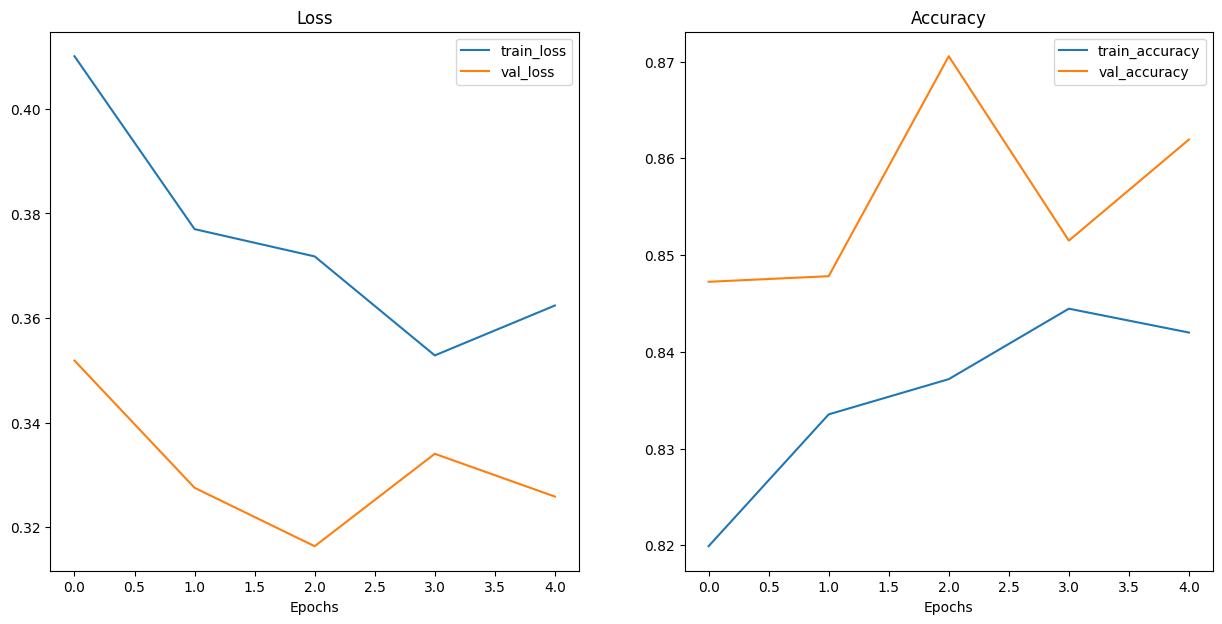

In [ ]:
# Plot the loss curves of our model
plot_loss_curves(results)

In [ ]:
from typing import List, Tuple

from PIL import Image

# 1. Take in a trained model, class names, image path, image size, a transform and target device
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms = None,
                        device: torch.device=device):


    # 2. Open image
    img = Image.open(image_path)

    # 3. Create transformation for image (if one doesn't exist)
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])

    ### Predict on image ###

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
      # 6. Transform and add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
      transformed_image = image_transform(img).unsqueeze(dim=0)

      # 7. Make a prediction on image with an extra dimension and send it to the target device
      target_image_pred = model(transformed_image.to(device))

    # 8. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 9. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 10. Plot image with predicted label and probability
    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
    plt.axis(False);

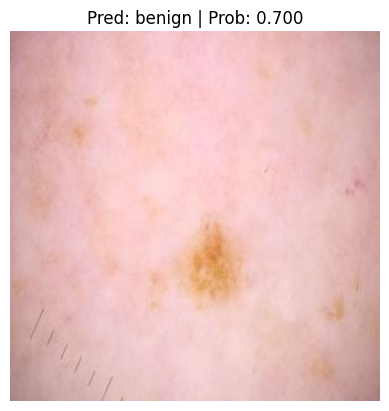

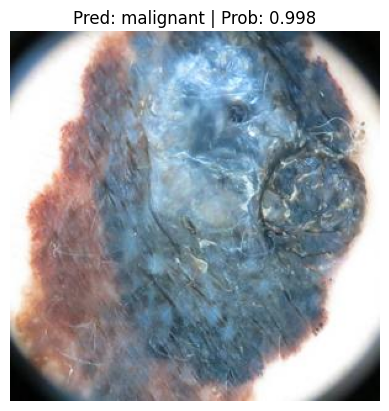

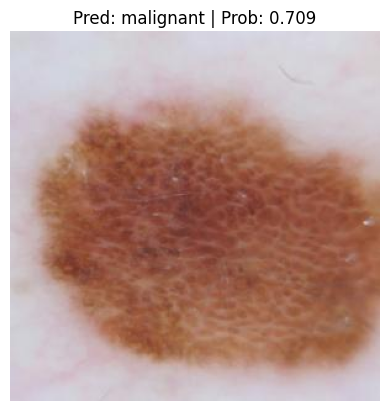

In [ ]:
# Get a random list of image paths from test set
import random
from pathlib import Path
num_images_to_plot = 3
test_image_path_list = list(Path(test_dest_path).glob("*/*.jpg")) # get list all image paths from test data
test_image_path_sample = random.sample(population=test_image_path_list, # go through all of the test image paths
                                       k=num_images_to_plot) # randomly select 'k' image paths to pred and plot

# Make predictions on and plot the images
for image_path in test_image_path_sample:
    pred_and_plot_image(model=model,
                        image_path=image_path,
                        class_names=class_names,
                        # transform=weights.transforms(), # optionally pass in a specified transform from our pretrained model weights
                        image_size=(224, 224))

## Performance

In [ ]:
test_accuracy, test_loss, recall = evaluate(model, test_dataloader, loss_fn, device)
print(f'Test Accuracy: {test_accuracy:.4f} | Test Loss: {test_loss:.4f} | Test Recall: {recall:.4f}')

100%|██████████| 17/17 [00:01<00:00,  8.68it/s]

Test Accuracy: 0.8663 | Test Loss: 0.3259 | Test Recall: 0.8663
